In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pickle
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

# This notebook niche
import keras.backend as K
import heapq

In [2]:
def sample(n=2000, dim=2, noise=0.3, seed=None):
    np.random.seed(seed)
    # More noise in the moons makes the task harder
    X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=noise)

    # Rescale and shift the dataset to better fit into zero-one box
    X = (X + 1.6) / 4
    X[:, 0] = X[:, 0] - 0.035
    X[:, 1] = (X[:, 1] - 0.17) * 1.75
    # y = tf.one_hot(y, depth=2)
    
    return X, y

X_train, y_train = sample(2000, noise=0.1, seed=1)
X_test, y_test = sample(2000, noise=0.1, seed=2)

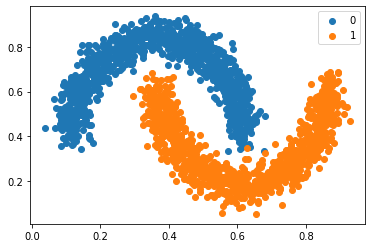

In [3]:
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0]
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label)
plt.legend()
plt.show()

In [9]:
def brute_predict(model, X):
    """ Otherwise, predict doesn't work with modified activations """
    for layer in model.layers:
        X = layer(X)
    return X.numpy()

def model2internal_rep(model, X):
    internal_rep = []
    act = X
    for layer in model.layers[:-1]:
        act = layer(act)
        internal_rep.append(act != 0)
    internal_rep = np.hstack(internal_rep).astype(int)
    return internal_rep

def plot_decision_boundaries(model, X, y, xlim=None, ylim=None, n_pts=100, title=None, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0]-0.5, xlim[1]+0.5, n_pts)
    yy = np.linspace(ylim[0]-0.5, ylim[1]+0.5, n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    # activations = polytope_membership(model, XY)
    colors = ['red', 'blue', 'black']
    internal_rep = model2internal_rep(model, XY)

    for relu_i in range(internal_rep.shape[1]):
        # Z = np.unique(internal_rep, axis=0, return_inverse=True)[1].reshape(XX.shape)
        Z = internal_rep[:, relu_i].reshape(XX.shape)
        CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)
    CS.collections[0].set_label('ReLU hyperplanes')
    
    predictions = np.argmax(brute_predict(model, XY), axis=1)
    Z_pred = predictions.reshape(XX.shape)
    CS = plt.contour(XX, YY, Z_pred, colors='black', alpha=1, linestyles='--')
    CS.collections[0].set_label('Softmax decision')

    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [4]:
# To remove relu by deleting output
class CustomConnected(tf.keras.layers.Dense):
    def __init__(self, units, connections=None, activations=None, **kwargs):

        #this is matrix A
        self.connections = connections  
        if activations is not None and type(activations) is not list:
            if type(activations) == str:
                self.activations = [tf.keras.activations.get(activations)] * units
            else:
                self.activations = [activations] * units
        else:
            self.activations = activations

        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activations is not None:
            slices = tf.unstack(output, axis=1)
            activated = []
            for s, act in zip(slices, self.activations):
                activated.append(act(s))
            output = tf.stack(activated, axis=1)
        elif self.activation is not None:
            output = self.activation(output)
        
        if self.connections is not None:
            output = tf.matmul(output, self.connections)
        
        return output
    
def zero_activation(X):
    return X*0

In [5]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

Fit model on training data, n_epochs 200
Epoch 1/200
63/63 [==============================] - 1s 5ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.2707 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8692 - val_loss: 0.2849 - val_sparse_categorical_accuracy: 0.8715
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2705 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.2636 - val_sparse_categorical_accuracy: 0.8790
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.8864 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.8785
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.2710 - val_sparse_categorical_accuracy: 0.8745
Epoch 6/200
63/63 [==============================] - 0s 2ms/step

63/63 [==============================] - 0s 2ms/step - loss: 0.2142 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.2124 - val_sparse_categorical_accuracy: 0.8990
Epoch 47/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.2006 - val_sparse_categorical_accuracy: 0.9105
Epoch 48/200
63/63 [==============================] - 0s 3ms/step - loss: 0.2020 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.1948 - val_sparse_categorical_accuracy: 0.9185
Epoch 49/200
63/63 [==============================] - 0s 3ms/step - loss: 0.1831 - sparse_categorical_accuracy: 0.9196 - val_loss: 0.1879 - val_sparse_categorical_accuracy: 0.9295
Epoch 50/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.1727 - val_sparse_categorical_accuracy: 0.9345
Epoch 51/200
63/63 [==============================] - 0s 3ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0230 - val_sparse_categorical_accuracy: 0.9920
Epoch 92/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0120 - val_sparse_categorical_accuracy: 0.9960
Epoch 93/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0105 - val_sparse_categorical_accuracy: 0.9970
Epoch 94/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0118 - val_sparse_categorical_accuracy: 0.9960
Epoch 95/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0081 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0132 - val_sparse_categorical_accuracy: 0.9960
Epoch 96/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.0077 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0063 - val_sparse_categorical_accuracy: 0.9980
Epoch 137/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0062 - val_sparse_categorical_accuracy: 0.9980
Epoch 138/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0191 - val_sparse_categorical_accuracy: 0.9935
Epoch 139/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0081 - val_sparse_categorical_accuracy: 0.9970
Epoch 140/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0063 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0089 - val_sparse_categorical_accuracy: 0.9960
Epoch 141/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0113 - sparse_categorical_accura

63/63 [==============================] - 0s 2ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0037 - val_sparse_categorical_accuracy: 0.9995
Epoch 182/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0071 - val_sparse_categorical_accuracy: 0.9980
Epoch 183/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0057 - val_sparse_categorical_accuracy: 0.9980
Epoch 184/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 0.9985
Epoch 185/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0120 - val_sparse_categorical_accuracy: 0.9945
Epoch 186/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0099 - sparse_categorical_accura

<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


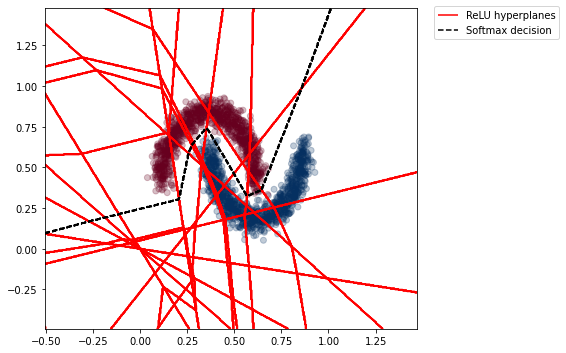

In [21]:
for epochs in [200]: # 1, 5, 10, 25, 50, 100, 
    print(f"Fit model on training data, n_epochs {epochs}")
    model = tf.keras.models.Sequential([
        CustomConnected(10, tf.eye(10), activations='relu'),
        CustomConnected(10, tf.eye(10), activations='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[metric],
    )

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=epochs,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        validation_data=(X_test, y_test),
    )
    plot_decision_boundaries(model, X_train, y_train, n_pts=500)

<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


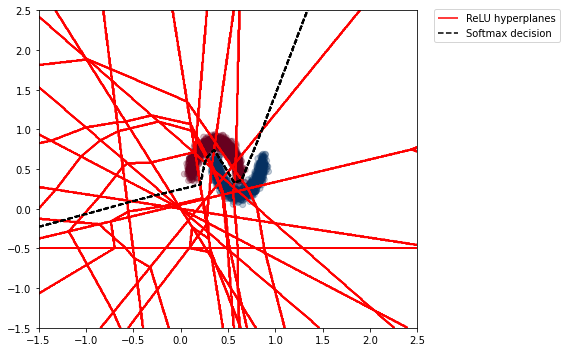

In [27]:
plot_decision_boundaries(model, X_train, y_train, n_pts=500, xlim=[-1, 2], ylim=[-1, 2])

## Prune ReLUs

In [65]:
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu

internal_rep = model2internal_rep(model, X_train)
relu_sep = (internal_rep.sum(0) - X_train.shape[0] / 2) / X_train.shape[0]
prune_order = np.argsort(-np.abs(relu_sep))
relu_layers = np.hstack([[i]*model.layers[i].units for i in range(len(model.layers) - 1)])

Test Accuracy=1.00, n_ReLUs=20


<ipython-input-9-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


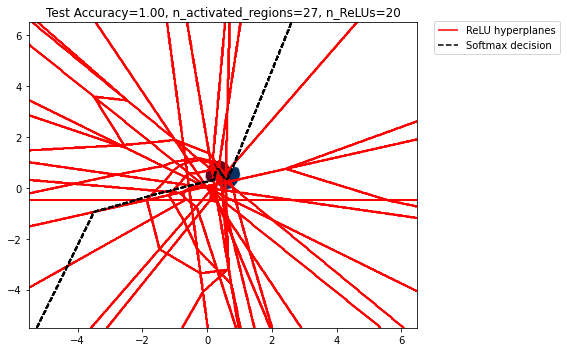

0: layer=0 relu_index=0


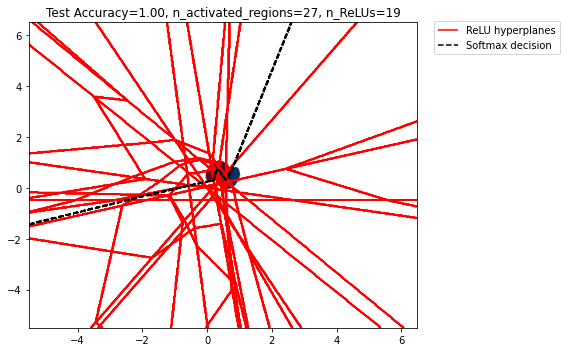

1: layer=1 relu_index=5


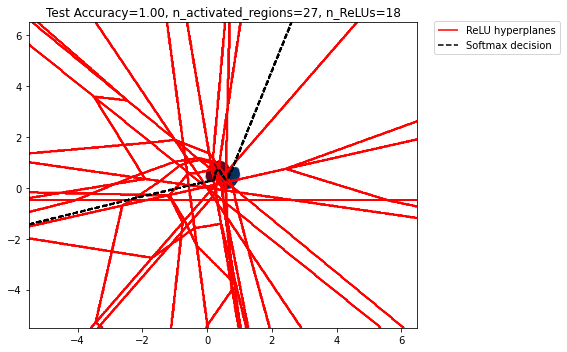

2: layer=1 relu_index=1


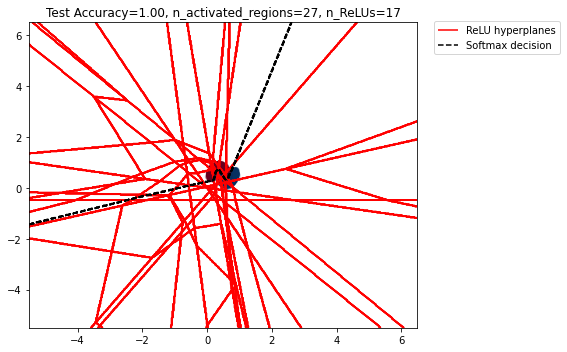

3: layer=1 relu_index=0


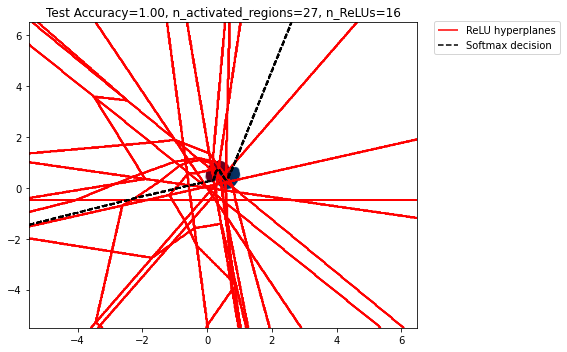

4: layer=0 relu_index=8


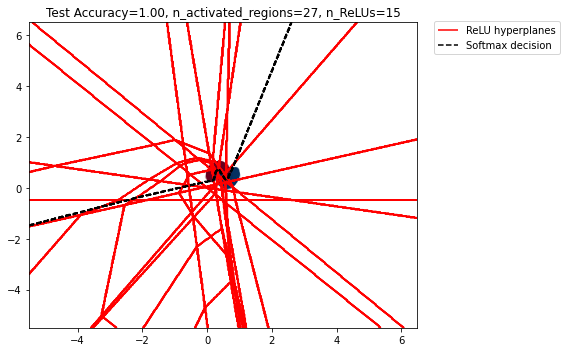

5: layer=1 relu_index=9


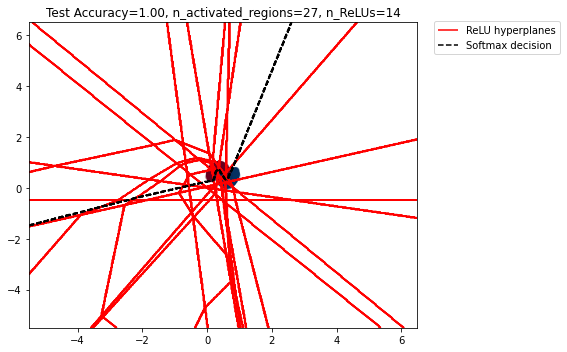

6: layer=0 relu_index=4


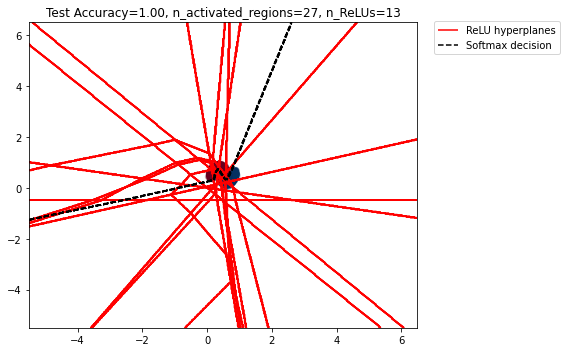

7: layer=0 relu_index=3


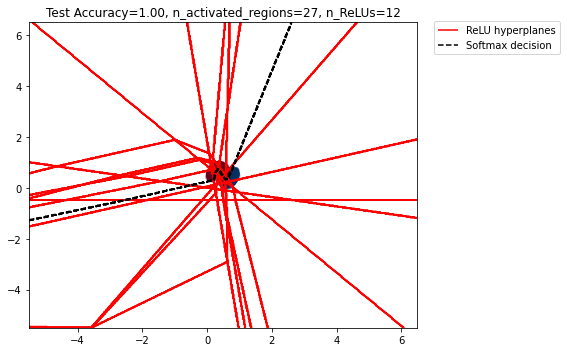

8: layer=0 relu_index=1


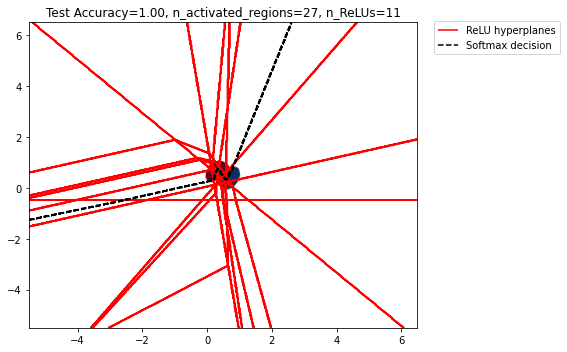

9: layer=0 relu_index=5


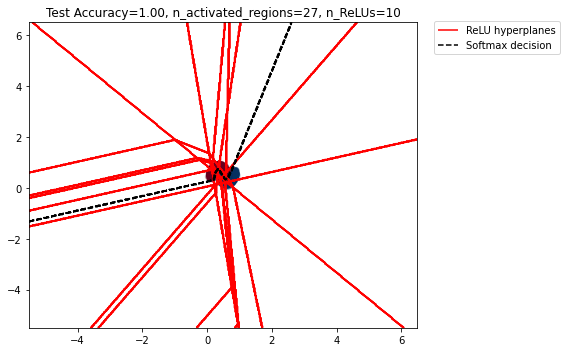

10: layer=1 relu_index=3


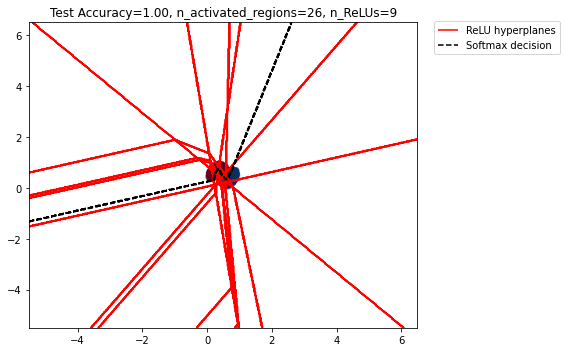

11: layer=0 relu_index=6


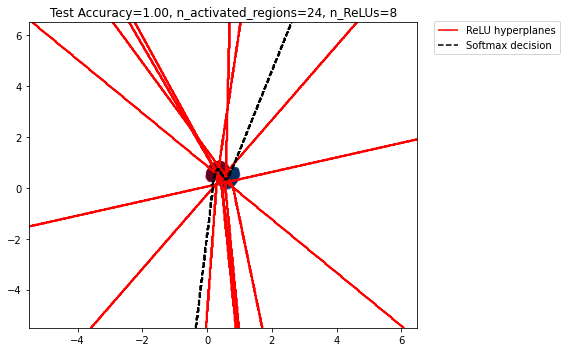

12: layer=0 relu_index=7


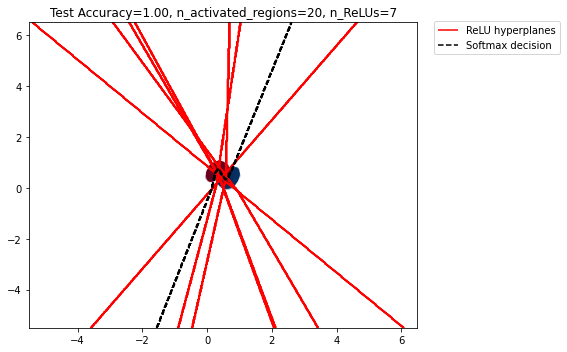

13: layer=1 relu_index=7


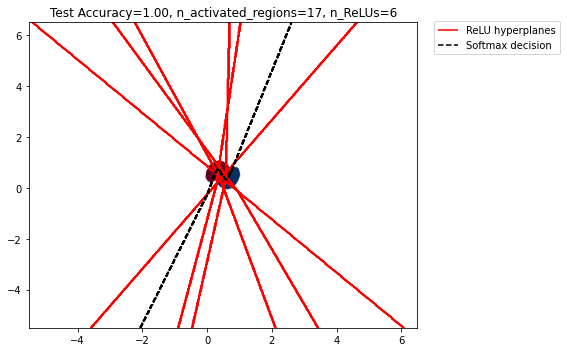

14: layer=1 relu_index=8


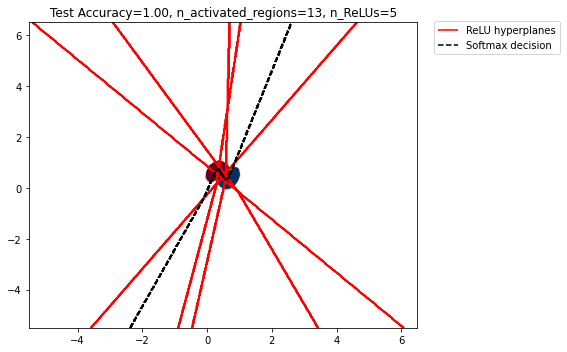

15: layer=1 relu_index=4


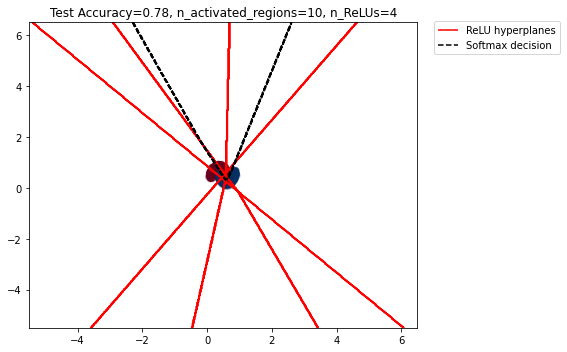

16: layer=0 relu_index=2


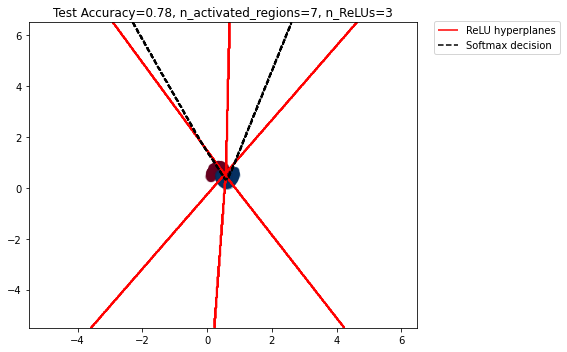

17: layer=1 relu_index=6


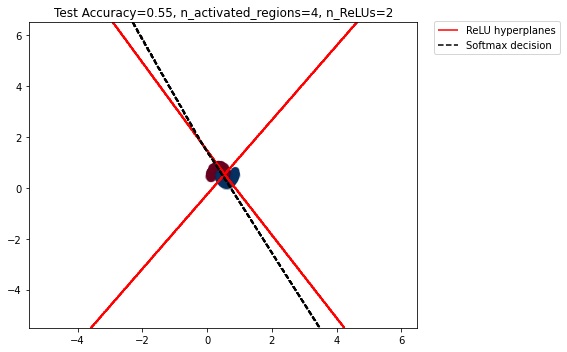

18: layer=1 relu_index=2


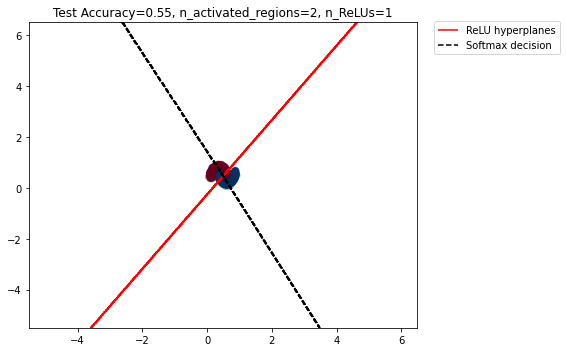

19: layer=0 relu_index=9


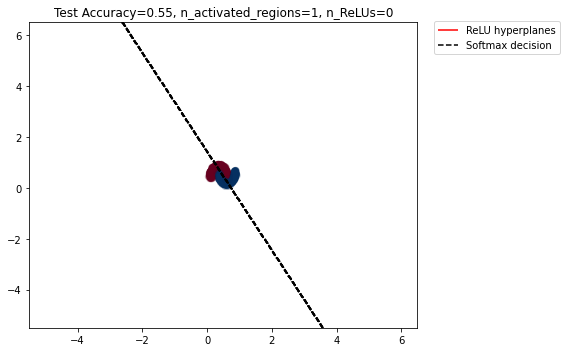

In [68]:
xlim=[-5, 6]; ylim=[-5, 6]
# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu

y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')

n_activated_regions = np.unique(internal_rep, axis=0).shape[0]
plot_decision_boundaries(
    model, X_train, y_train, n_pts=500,
    xlim=xlim, ylim=ylim,
    title=f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)}',
    save_path=f'./results/spiral_layers=2_hyperplanes_relus={len(prune_order)}.png'
)

# Plot
for count, idx in enumerate(prune_order):
    n_activated_regions = np.unique(internal_rep[:, prune_order[count+1:]], axis=0).shape[0]
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    plot_decision_boundaries(
        model, X_train, y_train, n_pts=500,
        xlim=xlim, ylim=ylim,
        title=f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)-count-1}',
        save_path=f'./results/spiral_layers=2_hyperplanes_relus={len(prune_order)-count-1}.png')

Full model
Test Accuracy=1.00, n_ReLUs=20


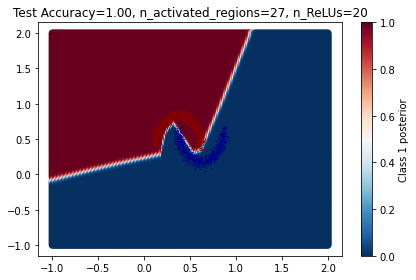

0: layer=0 relu_index=0


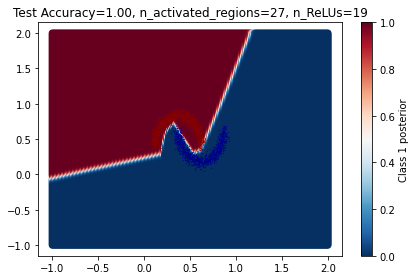

1: layer=1 relu_index=5


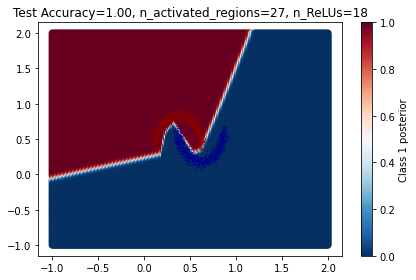

2: layer=1 relu_index=1


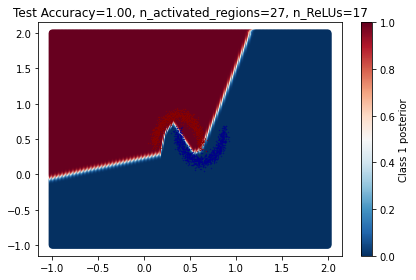

3: layer=1 relu_index=0


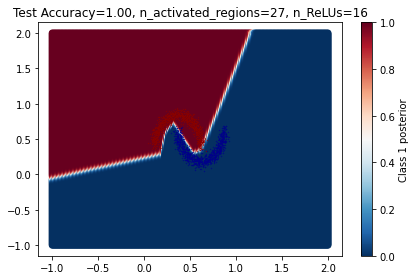

4: layer=0 relu_index=8


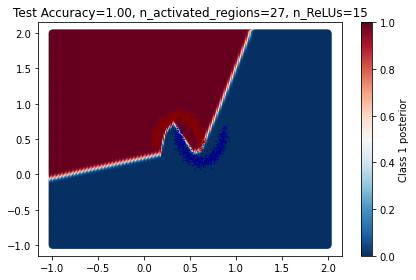

5: layer=1 relu_index=9


In [ ]:
from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu
print('Full model')
y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')
# plot_decision_boundaries(model, X_train, y_train, n_pts=250)
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200
n_activated_regions = np.unique(internal_rep, axis=0).shape[0]

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = brute_predict(model, XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
plt.colorbar(label='Class 1 posterior')

colors = ['darkred', 'darkblue']
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0]
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label, c=colors[label], s=0.1)

    
plt.title(f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)}')
plt.tight_layout()
plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)}.png')
plt.show()

# Plot
for count, idx in enumerate(prune_order):
    n_activated_regions = np.unique(internal_rep[:, prune_order[count+1:]], axis=0).shape[0]
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    # plot_decision_boundaries(model, X_train, y_train, n_pts=250)
    xlim = [-1, 2]
    ylim = [-1, 2]
    n_pts = 200

    xx = np.linspace(xlim[0], xlim[1], n_pts)
    yy = np.linspace(ylim[0], ylim[1], n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    probs = brute_predict(model, XY)

    z_plot = probs[:, 0].reshape(XX.shape)

    plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
    plt.colorbar(label='Class 1 posterior')
    
    colors = ['darkred', 'darkblue']
    for label in np.unique(y_train):
        idx = np.where(y_train == label)[0]
        plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label, c=colors[label], s=0.1)

    plt.title(f'Test Accuracy={test_accuracy:.2f}, n_activated_regions={n_activated_regions}, n_ReLUs={len(prune_order)-count-1}')
    plt.tight_layout()
    plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)-count-1}.png')
    plt.show()

In [ ]:
prune_order = np.argsort(-np.abs(relu_sep))

all_relus_

for purity in np.linspace(0.5 + 0.5 / res, 0, res+2):
    results['relu_hyperplane_balance'].append(1 - purity*2)
    
    prune_delete_edge = np.where(model_results['separation_frac'] <= -purity)[0]
    prune_delete_relu = np.where(model_results['separation_frac'] >= purity)[0]
    results['n_relus'].append(n_units - len(prune_delete_edge) - len(prune_delete_relu))
    
    # Prune relus that are always off
    prune_diag = np.ones(n_units).astype('float32')
    prune_diag[prune_delete_edge] = 0
    model.layers[1].connections = tf.constant(tf.linalg.diag(prune_diag))
    
    # Prune relus that are always on
    for idx in (prune_delete_relu):
        model.layers[1].activations[idx] = eye_activation
        
    active_relu_indices = np.setdiff1d(np.arange(n_units), np.concatenate((prune_delete_relu, prune_delete_edge)))
    evalues = evalues_from_regions(model_results['internal_rep'][:, active_relu_indices])
    results['n_activated_regions'].append(sum(evalues > 0))
        
    test_results = eval_model(model, metric, ds_test)
    for key, val in test_results.items():
        results['test_' + key].append(val)
        
    train_results = eval_model(model, metric, ds_train)
    for key, val in train_results.items():
        results['train_' + key].append(val)

In [137]:
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = model.predict(XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r')
plt.show()

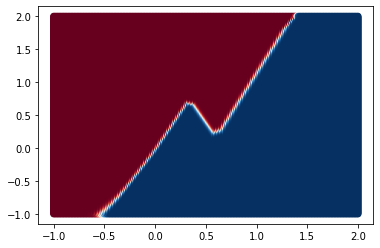

In [79]:
from mpl_toolkits import mplot3d

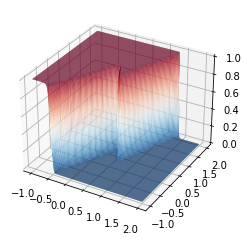

In [80]:
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, z_plot, rstride=1, cstride=1,
                cmap='RdBu_r', edgecolor='none')
plt.show()